# MCC-F1 Curve and Metrics

Based on the paper - The MCC-F1 curve: a performance evaluation technique for binary classification (Cao, Chicco, & Hoffman, 2020), wherein the authors combine two single-threshold metrics i.e. Matthews correlation coefficient (MCC) and the 𝐹1 score.
into a MCC-F1 curve and also compute a metric that integrates the MCC-F1 curve inorder to compare classifier performance across varying thresholds.

The below code computes the MCC-F1 curve and its relevant metrics.
* Based on 2 input values - Ground truths and Predicted values (given by a binary classifer);
* The MCC-F1 function calculates the MCC and F1 scores across varying thresholds.
* The MCC-F1 metric provides a measure to compare classifers, and provides the the best threshold 𝑇 the point on the MCC-𝐹1 curve closest to the point of perfect performance (1,1)
* Plotting the MCC-F1 curve.

***

# Import Necessary Python Packages

In [1]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# The MCC-F1 function:
Based on the inputs of ground truths and predicted values; we can calculate Matthews correlation coefficient (MCC) and the 𝐹1 scores which are scoring classifiers. 
This results in a real-valued prediction score 𝑓(𝑥𝑖) for each element, and then assigning positive predictions (𝑦𝑖̂ = 1) when the score exceeds some threshold 𝜏, or negative predictions (𝑦𝑖̂ = 0).

In [2]:
def mcc_f1(ground_truths, predticted_values):
    
    mcc = []   
    f1 = []
    
# Generating thresholds with the PRC function
    precision, recall, thresholds = metrics.precision_recall_curve(
                                    ground_truths, predticted_values)

# For every value of the thresholds (cutoffs), calculate MCC and F1 scores :
    for thresh in thresholds:
        y_pred_thresh = predticted_values > thresh
    
        mcc.append((metrics.matthews_corrcoef(
                    ground_truths, y_pred_thresh)+1)*0.5) # get normalised MCC: change the range of MCC from [-1, 1] to [0, 1] 
        
        f1.append(metrics.f1_score(
                    ground_truths, y_pred_thresh))
        
    mcc = np.array(mcc)
    f1 = np.array(f1)  
    
    return mcc,f1, thresholds
# Resulting values are an array of MCC & F1 scores across different thresholds (cutoffs)

# The MCC-F1 metric:

Based on the MCC-F1 scores calulated we can compute the MCC-F1 Metric based on the following steps:
* Divide the normalized MCC in the curve [min𝑖 𝑋𝑖, max𝑖 𝑋𝑖] into 𝑊 = 100 sub-ranges, each of width 𝑤 = (max𝑖 𝑋𝑖 − min𝑖 𝑋𝑖)/𝑊.
* calculate the mean Euclidean distance between points with MCC in each sub-range to the point of perfect performance (1,1).
* Calculate grand average i.e. averaged the mean distances amongst subranges.
* Better classifiers have MCC-𝐹1 curves closer to the point of perfect performance (1,1), and have a larger MCC-𝐹1 metric.

In [3]:
def MCC_F1_Metric(mcc,f1):
    W = 100 # number of subranges; larger values of 𝑊 will cause the MCC-𝐹1 metric to capture the performance of a classifier more accurately.
    mcc_intervals = np.linspace(np.min(mcc), np.max(mcc),W) # breaking into subranges
    
    # Computing MCC values per subrange
    
    n = np.zeros_like(mcc_intervals) # 'n' is the number of points per subrange
    for i in range(W-1):
        for j in mcc:
            if j >= mcc_intervals[i] and j < mcc_intervals[i+1]:
                n[i] = n[i] + 1

    # Calculating the distances between points in a subrange to the Point of perfect performance (1,1)            
    Di = np.zeros_like(mcc)
    Di = np.sqrt(((mcc-1)**2)+((f1-1)**2)) # calculating the Euclidean distance 𝐷𝑖            
    sum = np.zeros_like(mcc_intervals)
    index = -1
    for value in mcc:
        index += 1
        for i in range(W-1):
                 if value >= mcc_intervals[i] and value < mcc_intervals[i+1]:
                        sum[i] = sum[i] + Di[index]

# Mean Distance across subranges
    mean_Di = np.array(sum/n)
    P = 0  
    mean_Di_sum = 0
    for i in mean_Di:
        if not np.isnan(i):
            P += 1 
            mean_Di_sum += i # addition of all the means across subranges that have atleast 1 MCC value.

    grand_avg = mean_Di_sum/P # P = total number of subranges that have atleast 1 MCC value
   
    """ 
    Compare the grand average distance to √2 (The distance between the point of worst performance (0,0) and 
    the point of perfect performance (1,1) is √2).That is the maximum possible distance between a point on the MCC-𝐹1 curve
    The ratio between the grand avgerage distance and √2 is taken.
    This ratio ranges between 0 and 1 (worst value = 0; best value = 1). To get the MCC-𝐹1 score, we subtract this ratio from 1
    """

    MCC_F1_Met = 1 - (grand_avg /np.sqrt(2))
  
    """""
    Finding the best threshold 𝑇 the point on the MCC-𝐹1 curve closest to the point of perfect performance (1,1).
    This threshold maximizes the overall advantage in MCC and 𝐹1 score
    """""

    result = np.where(Di == Di.min())
    T_index = result[0][0]
    
    print("MCC-F1 metric = {0:.2f}".format(MCC_F1_Met), "Best Threshold = {0:.2f}".format(thresholds[T_index]))
    
    return MCC_F1_Met,T_index

# Example

In [4]:
# Populating ground truth values

x = np.array([1,0])
ground_truths = np.repeat(x,[1000,10000])

"""
Populating Predcition values (based on a beta distribution, this bimodal piecewise 
distribution simulates a classifier with large recall when the threshold nears 1
and small recall when the threshold nears 0).
"""

b1 = np.random.beta(12,2,300)
b2 = np.random.beta(3,4,700)
b3 = np.random.beta(2,3,10000)
predticted_values = np.concatenate([b1,b2,b3])


# Calling the 2 functions:

In [5]:
mcc,f1,thresholds = mcc_f1(ground_truths,predticted_values)
MCC_F1_Met,T_index = MCC_F1_Metric(mcc,f1)


MCC-F1 metric = 0.39 Best Threshold = 0.79


# Ploting the MCC-F1 curve:

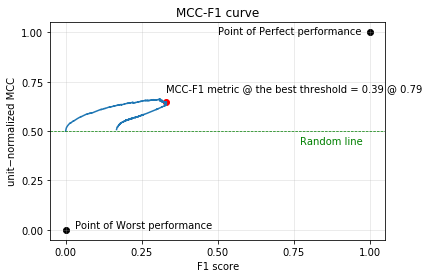

In [6]:
# Generating a plot;
fig = plt.figure()
ax = fig.add_subplot(111)

# Labelling the plot;
ax.plot(f1,mcc)
ax.set(xlabel='F1 score', 
       ylabel='unit−normalized MCC',
       title='MCC-F1 curve')

# Inserting Random line
ax.axhline(0.5,linewidth=0.7, color='green',linestyle='--')
ax.annotate('Random line',xy =(0,0.5),xytext=(250,-15),
            color='g', xycoords = ax.get_yaxis_transform(), 
            textcoords="offset points", va="bottom")

# Labelling MCC-F1 metric results
ax.annotate("MCC-F1 metric @ the best threshold = {0:.2f} @ {1:.2f}".format(
            MCC_F1_Met, thresholds[T_index]), 
                 (f1[T_index],mcc[T_index]), 
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='left') 

# Displaying and labelling points of performances.
ax.scatter(f1[T_index],mcc[T_index],color='red')
ax.scatter(1,1,color = 'black');ax.scatter(0,0,color = 'black')
ax.annotate('Point of Perfect performance',(1,1),
            textcoords="offset points",xytext=(-9,-2),ha='right')
ax.annotate('Point of Worst performance',(0,0)
            ,textcoords="offset points",xytext=(9,2),ha='left')

# Displaying the plot
plt.xticks(np.arange(0, 1.1, 0.25)); plt.yticks(np.arange(0, 1.1, 0.25))
plt.xlim(-0.05,1.05); plt.ylim(-0.05,1.05)
plt.grid(alpha = 0.3)
plt.show()

***

## Example (multiple datasets):

In [7]:
# Populating ground truth values

#Ground truth datasets (x, y,z)
x = np.array([1,0])
ground_truths_x = np.repeat(x,[1000,10000])

y = np.array([1,0])
ground_truths_y = np.repeat(y,[10000,1000])

z = np.array([1,0])
ground_truths_z = np.repeat(z,[10000,10000])

"""
Populating Predcition values (based on a beta distribution, this bimodal piecewise 
distribution simulates a classifier with large recall when the threshold nears 1
and small recall when the threshold nears 0).
"""
# prediction scores of classifier A:
x1 = np.random.beta(12,2,300)
x2 = np.random.beta(3,4,700)
x3 = np.random.beta(2,3,10000)
predticted_values_Ax = np.concatenate([x1,x2,x3])

y1 = np.random.beta(12,2,3000)
y2 = np.random.beta(3,4,7000)
y3 = np.random.beta(2,3,1000)
predticted_values_Ay = np.concatenate([y1,y2,y3])

z1 = np.random.beta(12,2,3000)
z2 = np.random.beta(3,4,7000)
z3 = np.random.beta(2,3,10000)
predticted_values_Az = np.concatenate([z1,z2,z3])

#prediction scores of classifier B
X1 = np.random.beta(2,3,10000)
X2 = np.random.beta(4,3,1000)

predticted_values_Bx = np.concatenate([X1,X2])

Y1 = np.random.beta(2,3,1000)
Y2 = np.random.beta(4,3,10000)

predticted_values_By = np.concatenate([Y1,Y2])

Z1 = np.random.beta(2,3,10000)
Z2 = np.random.beta(4,3,10000)

predticted_values_Bz = np.concatenate([Z1,Z2])


In [8]:
#Ax
mcc_Ax,f1_Ax,thresholds_Ax = mcc_f1(ground_truths_x,predticted_values_Ax)
MCC_F1_Met_Ax,T_index_Ax = MCC_F1_Metric(mcc_Ax,f1_Ax)


#Bx
mcc_Bx,f1_Bx,thresholds_Bx = mcc_f1(ground_truths_x,predticted_values_Bx)
MCC_F1_Met_Bx,T_index_Bx = MCC_F1_Metric(mcc_Bx,f1_Bx)

#Ay

mcc_Ay,f1_Ay,thresholds_Ay = mcc_f1(ground_truths_y,predticted_values_Ay)
MCC_F1_Met_Ay,T_index_Ay = MCC_F1_Metric(mcc_Ay,f1_Ay)

#By

mcc_By,f1_By,thresholds_By = mcc_f1(ground_truths_y,predticted_values_By)
MCC_F1_Met_By,T_index_By = MCC_F1_Metric(mcc_By,f1_By)

#Az

mcc_Az,f1_Az,thresholds_Az = mcc_f1(ground_truths_z,predticted_values_Az)
MCC_F1_Met_Az,T_index_Az = MCC_F1_Metric(mcc_Az,f1_Az)

#Bz

mcc_Bz,f1_Bz,thresholds_Bz = mcc_f1(ground_truths_z,predticted_values_Bz)
MCC_F1_Met_Bz,T_index_Bz = MCC_F1_Metric(mcc_Bz,f1_Bz)


MCC-F1 metric = 0.39 Best Threshold = 0.79
MCC-F1 metric = 0.29 Best Threshold = 0.04
MCC-F1 metric = 0.39 Best Threshold = 0.10
MCC-F1 metric = 0.52 Best Threshold = 0.03
MCC-F1 metric = 0.50 Best Threshold = 0.33
MCC-F1 metric = 0.32 Best Threshold = 0.03


In [9]:
def plotting(mcc, f1,MCC_F1_Met, thresholds,T_index,classifer_name, ax):
        ax.plot(f1,mcc)
        ax.annotate(classifer_name + "_MCC_Met - {0:.2f}".format(
            MCC_F1_Met), 
                 (f1[T_index],mcc[T_index]), 
                 textcoords="offset points", 
                 xytext=(0,10),
                 ha='left') 
        
        ax.scatter(f1[T_index],mcc[T_index],color='red')
        ax.set(xlabel='F1 score',
               ylabel='unit−normalized MCC',title='MCC-F1 curve')
        
        # Inserting Random line
        ax.axhline(0.5,linewidth=0.7, color='green',linestyle='--')
        ax.annotate('Random line',xy =(0,0.5),xytext=(250,-15),
                    color='g', xycoords = ax.get_yaxis_transform(), 
                    textcoords="offset points", va="bottom")


        # Displaying and labelling points of performances.

        ax.scatter(1,1,color = 'black');ax.scatter(0,0,color = 'black')
        ax.annotate('Point of Perfect performance',(1,1),
                    textcoords="offset points",xytext=(-9,-2),ha='right')
        ax.annotate('Point of Worst performance',(0,0)
                    ,textcoords="offset points",xytext=(9,2),ha='left')
        
        ax.set_xticks(np.arange(0, 1.1, 0.25)); ax.set_yticks(np.arange(0, 1.1, 0.25))
        ax.set_xlim(-0.05,1.05); ax.set_ylim(-0.05,1.05)
        ax.grid(alpha = 0.3)

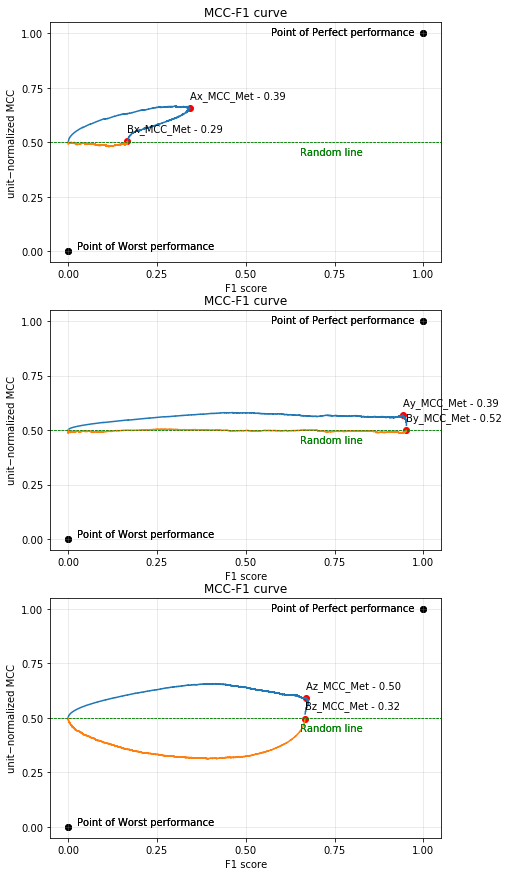

In [10]:
# Generating a plot;
fig = plt.figure(figsize=(7,15))
axis = []
for i in range(1,4):
    ax = fig.add_subplot(3, 1, i)
    axis.append(ax)

# Labelling the plot;
plotting(mcc_Ax,f1_Ax,MCC_F1_Met_Ax,thresholds_Ax,T_index_Ax,'Ax', axis[0])
plotting(mcc_Bx,f1_Bx,MCC_F1_Met_Bx,thresholds_Bx,T_index_Bx,'Bx', axis[0])
plotting(mcc_Ay,f1_Ay,MCC_F1_Met_Ay,thresholds_Ay,T_index_Ay,'Ay', axis[1])
plotting(mcc_By,f1_By,MCC_F1_Met_By,thresholds_By,T_index_By,'By', axis[1])
plotting(mcc_Az,f1_Az,MCC_F1_Met_Az,thresholds_Az,T_index_Az,'Az', axis[2])
plotting(mcc_Bz,f1_Bz,MCC_F1_Met_Bz,thresholds_Bz,T_index_Bz,'Bz', axis[2])

plt.show()

***